In [30]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from matplotlib.colors import ListedColormap

# Decision Tree Classifier: Create and Train the model
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
import pandas_datareader as pdr  # ดึงข้อมูลจากที่อื่นได้หมด
import random, warnings
from sklearn.datasets import load_boston

import matplotlib
import seaborn as sns
import statsmodels.api as sm  # pip install statsmodels
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
import talib

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import absolute
from numpy import sqrt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [31]:
pd.options.display.float_format = "{:,.3f}".format
warnings.simplefilter(action='ignore', category=FutureWarning)
random.seed(123)

In [32]:
# download dataframe
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']
NUM_DAYS = 730      # จำนวนวันย้อนหลังที่จะดึงข้อมูล
INTERVAL = '1d'     # อัตราตัวอย่างข้อมูลย้อนหลัง
symbol = '000001.SS'      # สัญลักษณ์ของหุ้น
start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) ) #4 ปี
end = datetime.datetime.today()

SSE = yf.download(symbol, start='2019-12-04', end='2021-12-04', interval=INTERVAL)
SSE

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-04,"2,876.908","2,882.498","2,869.422","2,878.116","2,878.116",125500
2019-12-05,"2,886.516","2,902.002","2,885.080","2,899.469","2,899.469",143200
2019-12-06,"2,902.278","2,912.014","2,894.751","2,912.014","2,912.014",134100
2019-12-09,"2,914.458","2,919.589","2,905.250","2,914.478","2,914.478",160800
2019-12-10,"2,908.944","2,919.201","2,902.790","2,917.316","2,917.316",170100
...,...,...,...,...,...,...
2021-11-29,"3,528.670","3,563.680","3,526.360","3,562.700","3,562.700",333600
2021-11-30,"3,570.750","3,582.120","3,546.360","3,563.890","3,563.890",349200
2021-12-01,"3,561.890","3,576.890","3,558.690","3,576.890","3,576.890",329900


In [33]:
def get_indicator(data):
    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema15'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['Volume'] / data['Volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['Open'])
    del (data['High'])
    del (data['Low'])
    del (data['Volume'])
    del (data['Adj Close'])
    
    return data

data = get_indicator(SSE)
print(SSE.columns)
data.fillna(method='bfill',inplace=True)
data

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


,Close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol
Date,,,,,,,,,,,,,,,,,,,,
2019-12-04,"2,878.116",100.000,0.000,0.000,54.912,"41,383.437",25.519,138.928,62.107,4.406,"143,200.000",66.667,826.175,0.716,1.175,1.000,1.000,1.000,1.000,1.000
2019-12-05,"2,899.469",100.000,0.479,0.266,54.912,"141,713.515",25.519,138.928,62.107,4.406,"143,200.000",66.667,826.175,0.716,1.175,1.004,1.004,1.004,1.003,1.060
2019-12-06,"2,912.014",100.000,0.999,0.567,54.912,"275,813.515",25.519,138.928,62.107,4.406,"277,300.000",83.280,826.175,0.716,1.175,1.005,1.005,1.005,1.005,0.995
2019-12-09,"2,914.478",100.000,1.301,0.815,54.912,"321,981.264",25.519,138.928,62.107,4.406,"438,100.000",86.018,826.175,0.716,1.175,1.005,1.004,1.004,1.004,1.123
2019-12-10,"2,917.316",100.000,1.550,1.034,54.912,"453,004.750",25.519,138.928,62.107,4.406,"608,200.000",68.362,826.175,0.716,1.175,1.004,1.004,1.004,1.003,1.129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-29,"3,562.700",51.831,5.363,-1.054,74.053,"24,860,958.813",31.311,29.400,44.690,0.847,"9,579,400.000",41.136,192.408,0.850,1.058,1.004,1.002,1.002,1.000,1.037
2021-11-30,"3,563.890",52.096,5.264,0.210,67.603,"24,854,118.953",29.682,42.100,52.016,0.700,"9,928,600.000",66.268,665.571,0.778,1.226,1.005,1.002,1.002,1.001,1.070
2021-12-01,"3,576.890",55.009,6.164,1.401,71.163,"25,184,018.953",27.313,39.520,52.152,1.234,"10,258,500.000",73.461,282.842,0.864,1.188,1.008,1.006,1.006,1.004,1.009


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

cols = list(data.drop("Close", axis=1).columns)
X = data.drop("Close", axis=1).values  # Feature Matrix
y = data["Close"].values
rfe = RFE(estimator=LinearRegression())
rfe.fit(X,y)
print(rfe.support_)
print(rfe.ranking_)

temp = pd.Series(rfe.support_, index = cols)
selected_features_rfe = temp[temp==True].index
selected_features_rfe

[ True False  True False False False False False False False False False
  True  True  True  True  True  True  True]
[ 1  3  1  6 10  5  8  4  2 11  7  9  1  1  1  1  1  1  1]


Index(['14 period RSI', 'SIGNAL', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15',
       'ema5', 'normVol'],
      dtype='object')

In [35]:
datapredict = data[selected_features_rfe].join(data['Close'])
datapredict

,14 period RSI,SIGNAL,VIm,VIp,ema50,ema21,ema15,ema5,normVol,Close
Date,,,,,,,,,,
2019-12-04,100.000,0.000,0.716,1.175,1.000,1.000,1.000,1.000,1.000,"2,878.116"
2019-12-05,100.000,0.266,0.716,1.175,1.004,1.004,1.004,1.003,1.060,"2,899.469"
2019-12-06,100.000,0.567,0.716,1.175,1.005,1.005,1.005,1.005,0.995,"2,912.014"
2019-12-09,100.000,0.815,0.716,1.175,1.005,1.004,1.004,1.004,1.123,"2,914.478"
2019-12-10,100.000,1.034,0.716,1.175,1.004,1.004,1.004,1.003,1.129,"2,917.316"
...,...,...,...,...,...,...,...,...,...,...
2021-11-29,51.831,-1.054,0.850,1.058,1.004,1.002,1.002,1.000,1.037,"3,562.700"
2021-11-30,52.096,0.210,0.778,1.226,1.005,1.002,1.002,1.001,1.070,"3,563.890"
2021-12-01,55.009,1.401,0.864,1.188,1.008,1.006,1.006,1.004,1.009,"3,576.890"


In [36]:
pred_future_days = 30
datapredict = data
datapredict['pred'] = datapredict[['Close']].shift(-pred_future_days)
X = np.array(datapredict.drop(['pred'],1))[:-pred_future_days]
y = np.array(datapredict['pred'])[:-pred_future_days]
X_train, X_test, y_train, y_test = train_test_split( X , y, test_size=0.15, random_state=0)

LR = LinearRegression()
LR.fit(X_train, y_train)

future_pred = datapredict.drop(['pred'],1)[:-pred_future_days]
future_pred = future_pred.tail(pred_future_days)
future_pred = np.array(future_pred)

LR_prediction = LR.predict(future_pred)
LR_prediction

predictions = LR_prediction

valid = datapredict[X.shape[0]:]
valid['pred'] = predictions

C:\Users\USER\AppData\Local\Temp/ipykernel_15884/470962726.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predictions


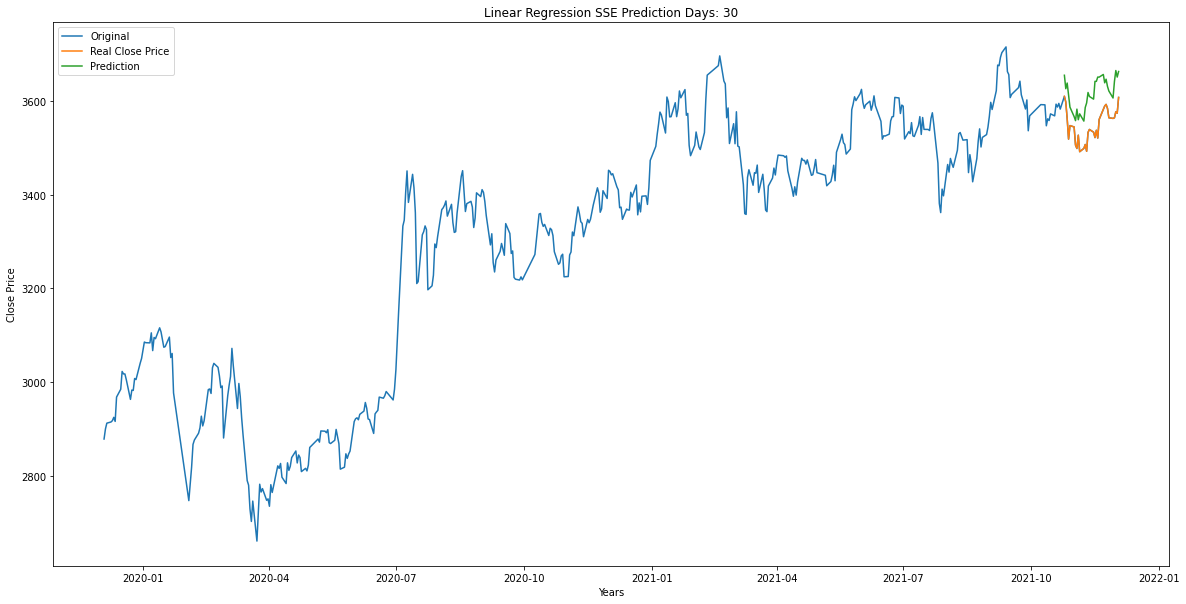

In [37]:

plt.figure(figsize=(20,10))
plt.title('Linear Regression SSE Prediction Days: %d' %pred_future_days)
plt.xlabel('Years')
plt.ylabel('Close Price')
plt.plot(data['Close'])
plt.plot(valid[['Close','pred']])
plt.legend(['Original','Real Close Price','Prediction'])
plt.show()

In [38]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)

#use k-fold CV to evaluate model
r2_scores_lr = cross_val_score(LR, X_train, y_train, scoring='r2',
                         cv=cv, n_jobs=-1)

#view r2 score
print(mean(absolute(r2_scores_lr)))

0.8103112942177255


In [39]:
rmse_scores_lr = cross_val_score(LR, X_train, y_train, scoring='neg_root_mean_squared_error',
                         cv=cv, n_jobs=-1)

#view rmse score
print(rmse_scores)
print(mean(absolute(rmse_scores_lr)))

[-84.17479974 -86.04795561 -86.1332908  -90.56879437 -80.43036396]
114.63313935146834


Polynomail regression

C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.73042e-32): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\USER\AppData\Local\Temp/ipykernel_15884/2804466549.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predictions


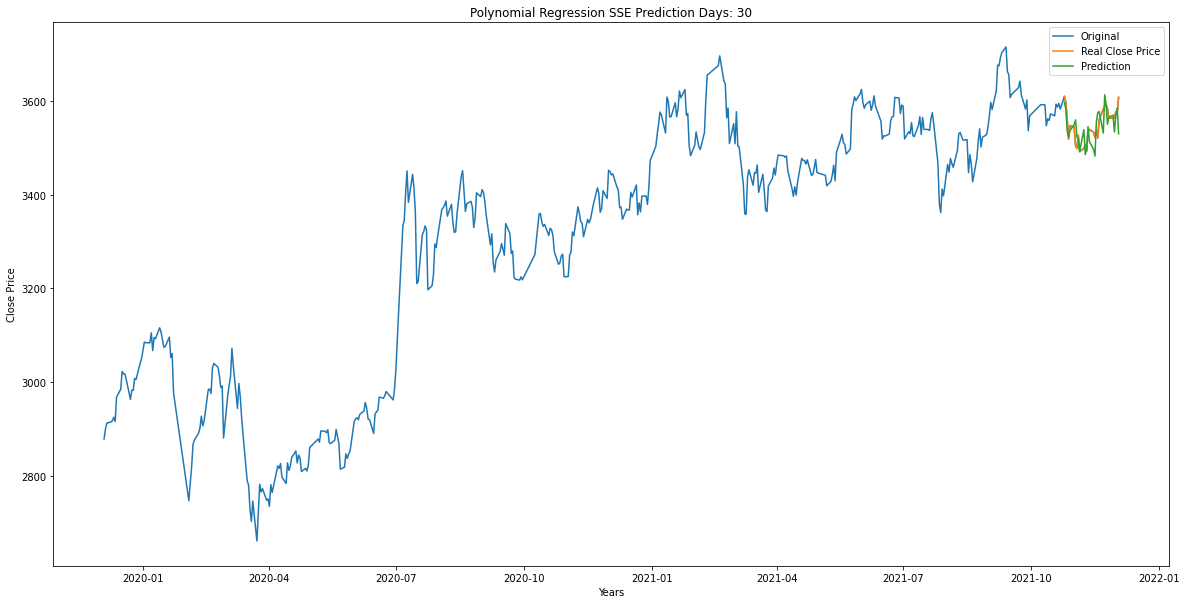

In [40]:

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pred_future_days = 30
datapredict = data
datapredict['pred'] = datapredict[['Close']].shift(-pred_future_days)
X = np.array(datapredict.drop(['pred'],1))[:-pred_future_days]
y = np.array(datapredict['pred'])[:-pred_future_days]
X_train, X_test, y_train, y_test = train_test_split( X , y, test_size=0.15 ,random_state=0)

# OLS = sm.OLS(y_train,X_train).fit()

# features = PolynomialFeatures(degree=5)
# X_train_poly = features.fit_transform(X_train)
# X_test_poly = features.fit_transform(X_test)
# POLY = LinearRegression()
# POLY.fit(X_train_poly, y_train)
POLY = make_pipeline(PolynomialFeatures(2), Ridge())
POLY.fit(X_train, y_train)

future_pred = datapredict.drop(['pred'],1)[:-pred_future_days]
future_pred = future_pred.tail(pred_future_days)
future_pred = np.array(future_pred)

POLY_prediction = POLY.predict(future_pred)

predictions = POLY_prediction

valid = datapredict[X.shape[0]:]
valid['pred'] = predictions

plt.figure(figsize=(20,10))
plt.title('Polynomial Regression SSE Prediction Days: %d' %pred_future_days)
plt.xlabel('Years')
plt.ylabel('Close Price')
plt.plot(data['Close'])
plt.plot(valid[['Close','pred']])
plt.legend(['Original','Real Close Price','Prediction'])
plt.show()

In [41]:
cv = KFold(n_splits=5, random_state=0,shuffle=True)

#use k-fold CV to evaluate model
r2_scores_poly = cross_val_score(POLY, X_train, y_train, scoring='r2',
                         cv=cv, n_jobs=-1)

#view mean absolute error
print(mean(absolute(r2_scores_poly)))

0.9294389979175344


In [42]:
rmse_scores_poly = cross_val_score(POLY, X_train, y_train, scoring='neg_root_mean_squared_error',
                         cv=cv, n_jobs=-1)
print(mean(absolute(rmse_scores_poly)))

69.19910586935585


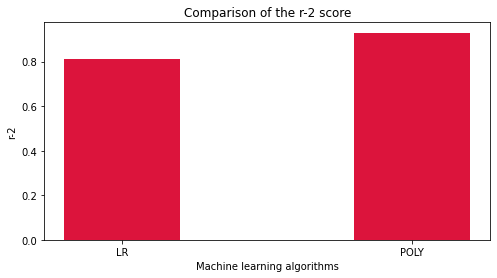

In [43]:
data = {'LR':np.mean(absolute(r2_scores_lr)), 'POLY':np.mean(absolute(r2_scores_poly))}

courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (8, 4))
 
# creating the bar plot
plt.bar(courses, values, color ='crimson',
        width = 0.4)
 
plt.xlabel("Machine learning algorithms")
plt.ylabel("r-2")
plt.title("Comparison of the r-2 score")
plt.show()